In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def K(x, sigma=1, dim=5):
    w = np.linalg.norm(x, ord=2)
    return np.exp(-w ** 2 / 2 / sigma**2) / (2 * np.pi * sigma**2)**(dim/2)

In [2]:
dataset = pd.read_csv('station_hour.csv')
dataset_na = dataset[dataset.isna().any(axis=1)].dropna(subset=['AQI'])
dataset = dataset.dropna().reset_index(drop=True)
feature_names = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene', 'Xylene']

In [3]:
from sklearn.model_selection import train_test_split
tmp1, tmp2 = train_test_split(dataset, test_size=0.5, random_state=42)
train_dataset, test_dataset = train_test_split(tmp1, test_size=0.01, random_state=42)
unlabeled_dataset, labeled_dataset = train_test_split(tmp2, test_size=0.0909090909, random_state=42)

train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)
unlabeled_dataset = unlabeled_dataset.reset_index(drop=True)
labeled_dataset = labeled_dataset.reset_index(drop=True)

In [4]:
from sklearn.model_selection import train_test_split
test_dataset = dataset.query("StationId == 'CH001'").reset_index(drop=True)
train_dataset, tmp = train_test_split(dataset.query("StationId != 'CH001'"), test_size=0.5, random_state=42)
train_dataset = pd.concat([train_dataset, dataset_na], ignore_index=True)
unlabeled_dataset, labeled_dataset = train_test_split(tmp, test_size=0.0909090909, random_state=42)

train_dataset = train_dataset.reset_index(drop=True)
test_dataset = test_dataset.reset_index(drop=True)
unlabeled_dataset = unlabeled_dataset.reset_index(drop=True)
labeled_dataset = labeled_dataset.reset_index(drop=True)

In [5]:
train_dataset.shape, test_dataset.shape, unlabeled_dataset.shape, labeled_dataset.shape

((1914299, 16), (5494, 16), (90090, 16), (9010, 16))

In [6]:
from sklearn.decomposition import PCA
pca_1 = PCA(n_components=1)
pca_1.fit(labeled_dataset[['PM2.5', 'PM10']])
test_dataset['PCA_1'] = pca_1.transform(test_dataset[['PM2.5', 'PM10']])
unlabeled_dataset['PCA_1'] = pca_1.transform(unlabeled_dataset[['PM2.5', 'PM10']])
labeled_dataset['PCA_1'] = pca_1.transform(labeled_dataset[['PM2.5', 'PM10']])

pca_2 = PCA(n_components=1)
pca_2.fit(labeled_dataset[[ 'NO', 'NO2', 'NOx', 'NH3']])
test_dataset['PCA_2'] = pca_2.transform(test_dataset[['NO', 'NO2', 'NOx', 'NH3']])
unlabeled_dataset['PCA_2'] = pca_2.transform(unlabeled_dataset[['NO', 'NO2', 'NOx', 'NH3']])
labeled_dataset['PCA_2'] = pca_2.transform(labeled_dataset[['NO', 'NO2', 'NOx', 'NH3']])

pca_3 = PCA(n_components=2)
pca_3.fit(labeled_dataset[['CO', 'SO2', 'O3']])
test_dataset[['PCA_3', 'PCA_4']] = pca_3.transform(test_dataset[['CO', 'SO2', 'O3']])
unlabeled_dataset[['PCA_3', 'PCA_4']] = pca_3.transform(unlabeled_dataset[['CO', 'SO2', 'O3']])
labeled_dataset[['PCA_3', 'PCA_4']] = pca_3.transform(labeled_dataset[['CO', 'SO2', 'O3']])
                                           
pca_4 = PCA(n_components=1)
pca_4.fit(labeled_dataset[['Benzene', 'Toluene', 'Xylene']])
test_dataset['PCA_5'] = pca_4.transform(test_dataset[['Benzene', 'Toluene', 'Xylene']])
unlabeled_dataset['PCA_5'] = pca_4.transform(unlabeled_dataset[['Benzene', 'Toluene', 'Xylene']])
labeled_dataset['PCA_5'] = pca_4.transform(labeled_dataset[['Benzene', 'Toluene', 'Xylene']])


In [7]:
mmin = labeled_dataset[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']].min()
mmax = labeled_dataset[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']].max()
test_dataset[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']] = (test_dataset[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']] - mmin) / (mmax - mmin)
labeled_dataset[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']] = (labeled_dataset[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']] - mmin) / (mmax - mmin)
unlabeled_dataset[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']] = (unlabeled_dataset[['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']] - mmin) / (mmax - mmin)


In [8]:
import xgboost
params = {
    'n_estimators': 100,
    'max_depth': 5,
    'learning_rate': 0.1,
    'objective': 'reg:squarederror',
    'n_jobs': -1,
    'tree_method': 'hist'
}
model = xgboost.XGBRegressor(**params)
model = model.fit(train_dataset[feature_names], train_dataset['AQI'])

In [9]:
labeled_dataset['pred'] = model.predict(labeled_dataset[feature_names])
unlabeled_dataset['pred'] = model.predict(unlabeled_dataset[feature_names])

In [10]:
def local_inference(target, labeled_set, unlabeled_set, h):
    target_X = target[feature_names].astype(float)

    X = np.concatenate([
        np.ones((1, len(labeled_set))),
        labeled_set[feature_names].sub(target_X.values, axis=1).T.values
    ])
    Y = labeled_set['AQI'].values.reshape(-1, 1)
    Y_F = labeled_set['pred'].values.reshape(-1, 1)
    W = np.array([K(x[1:]/h) for x in X.T])

    tilde_X = np.concatenate([
        np.ones((1, len(unlabeled_set))),
        unlabeled_set[feature_names].sub(target_X.values, axis=1).T.values
    ])
    tilde_Y_F = unlabeled_set['pred'].values.reshape(-1, 1)
    tilde_W = np.array([K(x[1:]/h) for x in tilde_X.T])
    beta = np.linalg.inv((X * W) @ X.T) @ (X * W) @ Y
    inference = beta[0]

    beta_ppi = np.linalg.inv((tilde_X * tilde_W) @ tilde_X.T) @ (tilde_X * tilde_W) @ tilde_Y_F - \
               np.linalg.inv((X * W) @ X.T) @ (X * W) @ (Y_F - Y)
    inference_ppi = beta_ppi[0]
    
    return (inference[0], inference_ppi[0], target['AQI'])

In [11]:
from tqdm import tqdm
feature_names = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']
error_df = pd.DataFrame(index=np.arange(len(test_dataset[:1000])*10), columns=['id', 'inference', 'inference_ppi', 'true'])
for i in tqdm(range(len(test_dataset[:1000]))):
    target = test_dataset.iloc[i]
    for j in range(10):
        unlabel_set = unlabeled_dataset.sample(20000, random_state=24+i*12+j)
        label_set = labeled_dataset.sample(2000, random_state=24+i*12+j)
        inference, inference_ppi, true = local_inference(target, label_set, unlabel_set, 0.7)
        error_df.loc[i*1000+j] = [i, inference, inference_ppi, true]

error_df = error_df.dropna().reset_index(drop=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [29:48<00:00,  1.79s/it]


In [12]:
error_df['error'] = (error_df['inference'] - error_df['true']).abs()
error_df['error_ppi'] = (error_df['inference_ppi'] - error_df['true']).abs()

In [13]:
record_df = pd.DataFrame(index=np.arange(len(test_dataset)), columns=['id', 'error', 'error_ppi', 'mse', 'mse_ppi', 'std', 'std_ppi'])
for i in range(len(test_dataset[:1000])):
    tmp = error_df.query("id == @i")
    error = (tmp['error']).mean()
    error_ppi = (tmp['error_ppi']).mean()
    mse = np.sqrt(((tmp['error'])**2).mean())
    mse_ppi = np.sqrt(((tmp['error_ppi'])**2).mean())
    std = (tmp['error']).std()
    std_ppi = (tmp['error_ppi']).std()
    record_df.loc[i] = [i, error, error_ppi, mse, mse_ppi, std, std_ppi]
# record_df['ppi_ratio']  = (record_df['std'] - record_df['std_ppi']) / (record_df['std_ppi'] + record_df['std']) * 2
# record_df['error_ratio'] = (record_df['error'] - record_df['error_ppi']) / (record_df['error_ppi'] + record_df['error']) * 2
# record_df['mse_ratio'] = (record_df['mse'] - record_df['mse_ppi']) / (record_df['mse_ppi'] + record_df['mse']) * 2
record_df['ppi_ratio']  = (record_df['std'] - record_df['std_ppi']) / (record_df['std']) 
record_df['error_ratio'] = (record_df['error'] - record_df['error_ppi']) / (record_df['error'])
record_df['mse_ratio'] = (record_df['mse'] - record_df['mse_ppi']) / (record_df['mse']) 
print(record_df['ppi_ratio'].mean(), record_df['error_ratio'].mean(), record_df['mse_ratio'].mean())


0.06922712513426761 -0.00022658570667567074 0.0028025247753412615


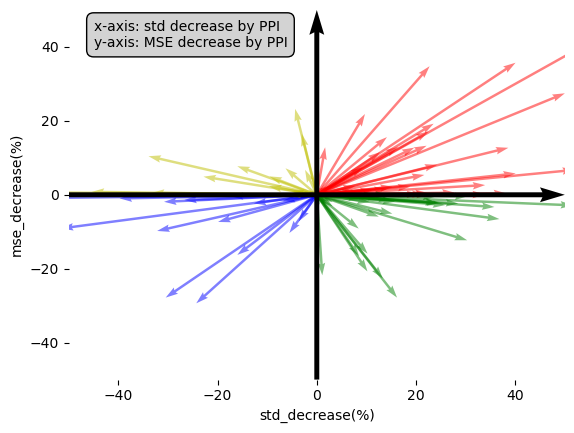

In [14]:
fig, ax = plt.subplots()
alpha = 0.5
for i in range(100):
    x, y = record_df.loc[i, ['ppi_ratio', 'mse_ratio']]
    x *= 100
    y *= 100
    if x > 0 and y > 0:
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='r', alpha=alpha, width=0.005)
    if x < 0 and y < 0:
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='b', alpha=alpha, width=0.005)
    if x > 0 and y < 0:
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='g', alpha=alpha, width=0.005)
    if x < 0 and y > 0:
        ax.quiver(0, 0, x, y, angles='xy', scale_units='xy', scale=1, color='y', alpha=alpha, width=0.005)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['left'].set_color('gray')
# ax.arrow(-0.8, 0, 1.18, 0, head_width=0.02, head_length=0.02, fc='k', ec='k')
# ax.arrow(0, -0.5, 0, 0.98, head_width=0.02, head_length=0.02, fc='k', ec='k')
ax.quiver(-80, 0, 130, 0, angles='xy', scale_units='xy', scale=1, color='k', width=0.01)
ax.quiver(0, -50, 0, 100, angles='xy', scale_units='xy', scale=1, color='k', width=0.01)

plt.annotate('x-axis: std decrease by PPI\ny-axis: MSE decrease by PPI', xy=(-45, 40),bbox=dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="lightgray"))
plt.xlim(-50, 50)
plt.ylim(-50, 50)
plt.xlabel('std_decrease(%)')
plt.ylabel('mse_decrease(%)')

plt.savefig('air_quality_arrow.png')

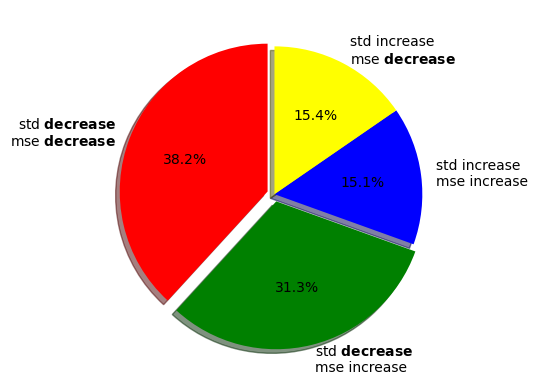

In [15]:
red, blue, green, yellow = 0, 0, 0, 0
for i in range(1000):
    x, y = record_df.loc[i, ['ppi_ratio', 'mse_ratio']]
    if x > 0 and y > 0:
        red += 1
    if x < 0 and y < 0:
        blue += 1
    if x > 0 and y < 0:
        green += 1
    if x < 0 and y > 0:
        yellow += 1

labels = [
    'std $\mathbf{decrease}$\nmse $\mathbf{decrease}$',
    'std $\mathbf{decrease}$\nmse increase',
    'std increase\nmse increase',
    'std increase\nmse $\mathbf{decrease}$'
]


plt.pie([red, green, blue, yellow], colors=['red', 'green', 'blue', 'yellow'], explode=(0.05, 0.05, 0, 0), autopct='%1.1f%%', shadow=True, startangle=90, labels=labels)

plt.savefig('air quality pie new.png')


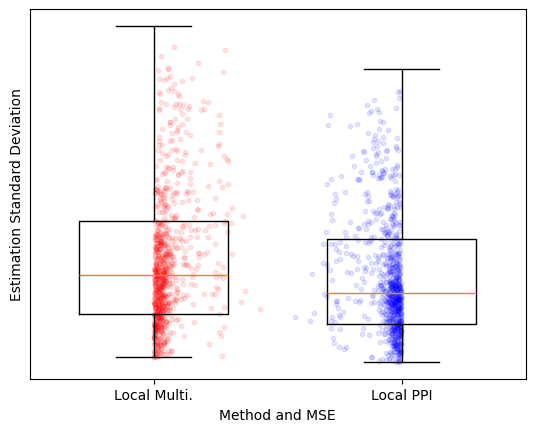

In [16]:
positions = [1, 2]

error_df_filtered = record_df.copy().dropna()

er, er_ppi = error_df_filtered['mse'], error_df_filtered['mse_ppi']
std, std_ppi = error_df_filtered['std'], error_df_filtered['std_ppi']

boxplot_dict = plt.boxplot([std, std_ppi], positions=positions, widths=0.6, showfliers=False, zorder=10, whis=[5, 95])

plt.xticks([1, 2], ['Local Multi.',  'Local PPI'])


upper_std = std.quantile(0.95)
lower_std = std.quantile(0.05)

upper_std_ppi = std_ppi.quantile(0.95)
lower_std_ppi = std_ppi.quantile(0.05)

x_scatter_1 = er / max(er_ppi.max(), er.max()) /1.5 + 1
y_scatter_1 = std 

x_scatter_2 = -er_ppi / max(er_ppi.max(), er.max()) /1.5+ 2
y_scatter_2 = std_ppi

whiskers = [item.get_ydata()[1] for item in boxplot_dict['whiskers']]
max_values = [whiskers[i*2+1] for i in range(2)]
min_values = [whiskers[i*2] for i in range(2)]


# Add title and labels
for i in range(len(er)):
    if y_scatter_2.iloc[i] < min_values[1] or y_scatter_2.iloc[i] > max_values[1]*0.95 or y_scatter_1.iloc[i] < min_values[0] or y_scatter_1.iloc[i] > max_values[0]*0.95:
        continue
    plt.scatter([x_scatter_1.iloc[i]], [y_scatter_1.iloc[i]], color='red', zorder=1, alpha=0.1, s=10)
    plt.scatter([x_scatter_2.iloc[i]], [y_scatter_2.iloc[i]], color='blue', zorder=1, alpha=0.1, s=10)


plt.xlabel('Method and MSE')
plt.ylabel('Estimation Standard Deviation')
plt.yticks([])

# plt.show()
plt.savefig('air_quality_box.png')